# MNISQ VQC — Blind Quantum Computing

Este notebook demonstra como treinar um modelo de Rede Neural Quântica (VQC)
usando o Qiskit Machine Learning e circuitos gerados a partir de arquivos QASM
da base MNIST.


In [1]:
#Instale as dependências (descomente e rode se necessário)
!pip install qiskit qiskit-aer qiskit-machine-learning qiskit-algorithms scikit-learn matplotlib numpy

In [ ]:
# Imports e configurações iniciais
import os
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss
from qiskit_algorithms.optimizers import COBYLA

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import seaborn as sns

%matplotlib inline

def show_figure(pict: np.array, index=0, fidelity=None):
    plt.imshow(pict.reshape(28, 28), cmap="Greys")
    plt.axis('off')
    title = f"Imagem {index}"
    if fidelity is not None:
        title += f" - Fidelidade: {fidelity:.6f}"
    plt.title(f"Imagem {index}")
    plt.show()
    plt.close()

def show_state_figure(state, index=0, fidelity=None):
    state_np = np.array(state)
    pict = np.abs(state_np[:784])
    show_figure(pict, index=index, fidelity=fidelity)

def mostrar_matriz_confusao(y_true, y_pred, classes=None, title='Matriz de Confusão'):
    """
    Calcula e mostra a matriz de confusão formatada
    """
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"\n{title}")
    print("=" * 30)
    
    if classes is None:
        classes = [f'Classe {i}' for i in range(len(cm))]
    
    # Cabeçalho
    header = "         " + " ".join(f"{cls:>8}" for cls in classes)
    print(header)
    print(" " * 9 + "-" * (len(classes) * 9))
    
    # Linhas da matriz
    for i, row in enumerate(cm):
        row_str = f"{classes[i]:<8} |"
        for val in row:
            row_str += f" {val:>7}"
        print(row_str)
    
    return cm

def mostrar_matriz_confusao_normalizada(y_true, y_pred, classes=None, title='Matriz de Confusão Normalizada'):
    """
    Calcula e mostra a matriz de confusão normalizada
    """
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    print(f"\n{title}")
    print("=" * 40)
    
    if classes is None:
        classes = [f'Classe {i}' for i in range(len(cm))]
    
    # Cabeçalho
    header = "         " + " ".join(f"{cls:>10}" for cls in classes)
    print(header)
    print(" " * 9 + "-" * (len(classes) * 11))
    
    # Linhas da matriz
    for i, row in enumerate(cm_norm):
        row_str = f"{classes[i]:<8} |"
        for val in row:
            row_str += f" {val:>9.3f}"
        print(row_str)
    
    return cm_norm

# Controle de Aleatoriedade e Reprodutibilidade

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

try:
    from qiskit_algorithms.utils import algorithm_globals
    algorithm_globals.random_seed = SEED
except Exception as e:
    print("Não foi possível configurar a semente global do Qiskit, continuando...", str(e))


# Callback: envio do circuito por época

In [1]:
def enviar_circuito_por_epoca(circuito, epoch, num_qubits, circuit_depth):
    print(f"[Epoch {epoch+1}] Enviando circuito para a rede (stub)...")
    try:
        rede.application_layer.run_app(
            "BFK_BQC",
            alice_id=6,
            bob_id=0,
            num_qubits=num_qubits,
            scenario=2,
            circuit_depth=circuit_depth,
            circuit=circuito
        )
        print(f"Circuit depth: {circuit_depth}, num_qubits: {num_qubits}")
    except Exception as e:
        print(f"[Epoch {epoch+1}] Erro ao enviar circuito: {str(e)}")


# Inicializar o Backend com Ruído

In [ ]:
# Configuração do modelo de ruído e do simulador (AER)
noise_model = NoiseModel()
error_1q = depolarizing_error(0.01, 1)  # 1% 1-qubit
error_2q = depolarizing_error(0.02, 2)  # 2% 2-qubit

# Adiciona erros para portas comuns (ajuste conforme seu conjunto de gates)
noise_model.add_all_qubit_quantum_error(error_1q, ['h', 'x', 'y', 'z', 'rx', 'ry', 'rz', 's', 'sdg', 't', 'tdg'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx', 'cz', 'swap'])

#simulator = AerSimulator(
#    noise_model=noise_model,
#    shots=1024,
#    method='statevector'
#)
simulator = AerSimulator(method='statevector')

print('Simulador configurado:', simulator)


Simulador configurado: AerSimulator('aer_simulator_statevector')


# Carregar os arquivos QASM da base MNIST.

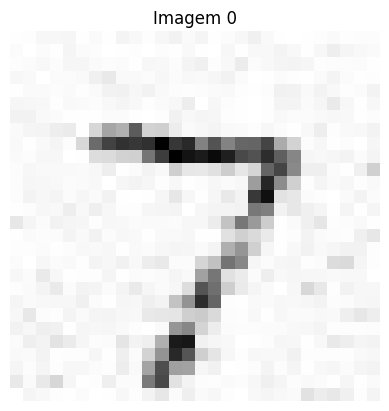

Fidelidade da imagem 0: 0.000001


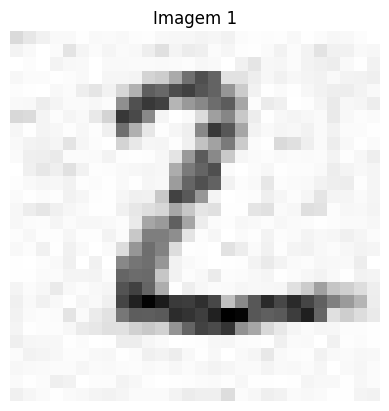

Fidelidade da imagem 1: 0.000989


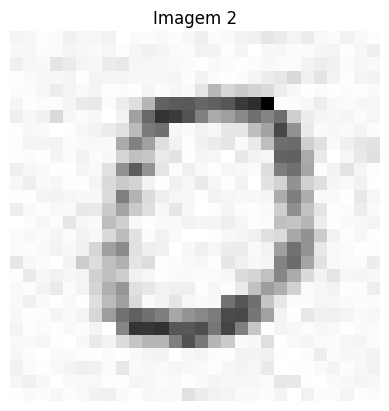

Fidelidade da imagem 2: 0.000132


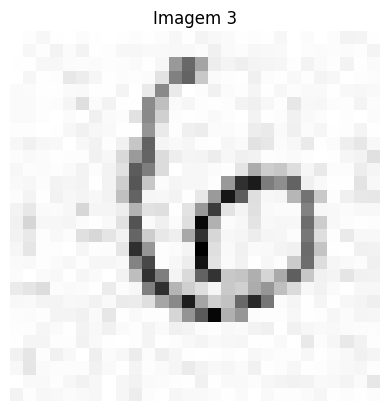

Fidelidade da imagem 3: 0.000000


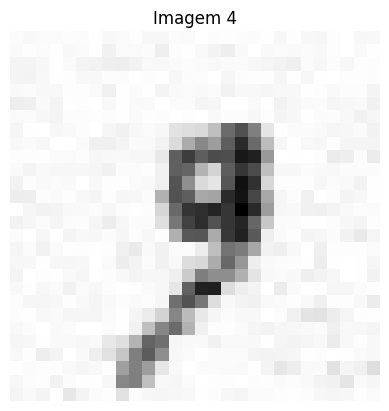

Fidelidade da imagem 4: 0.000023


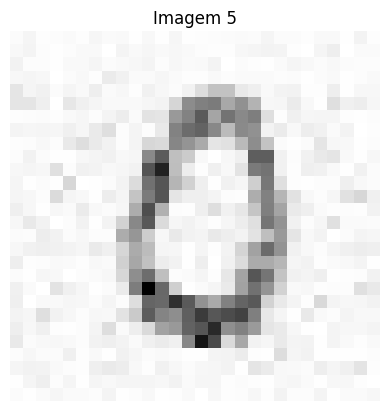

Fidelidade da imagem 5: 0.000021


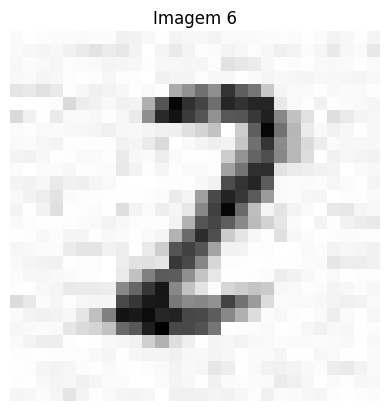

Fidelidade da imagem 6: 0.000023


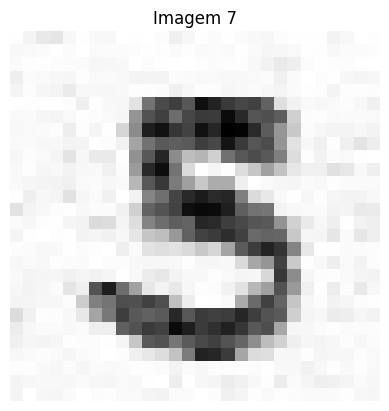

Fidelidade da imagem 7: 0.000001


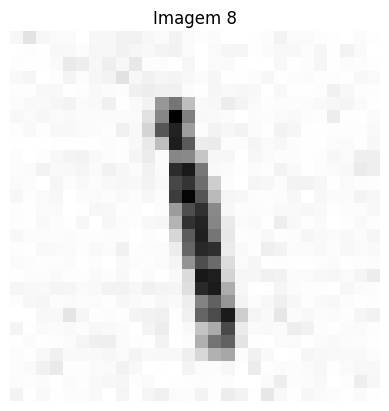

Fidelidade da imagem 8: 0.000108


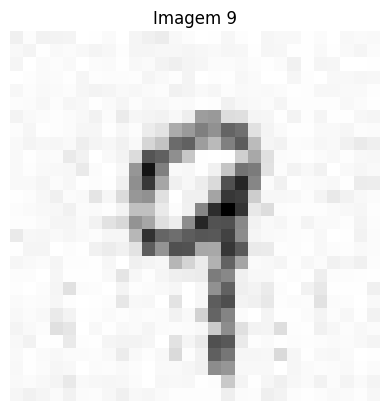

Fidelidade da imagem 9: 0.000383


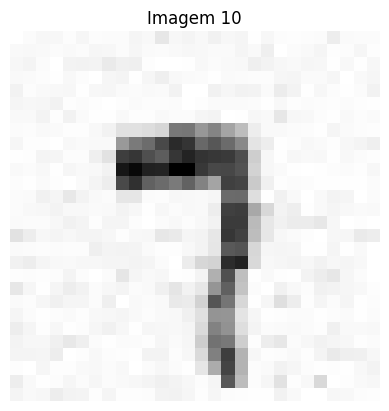

Fidelidade da imagem 10: 0.000000


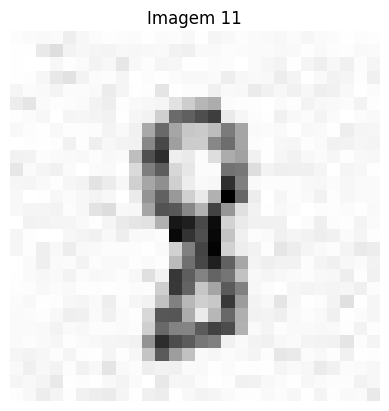

Fidelidade da imagem 11: 0.000008


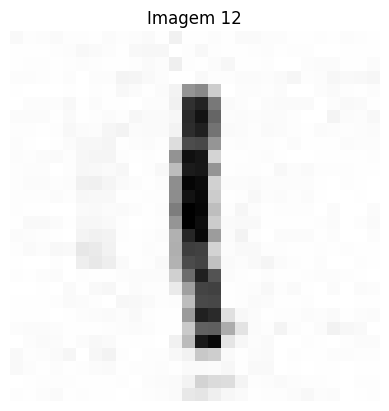

Fidelidade da imagem 12: 0.000052


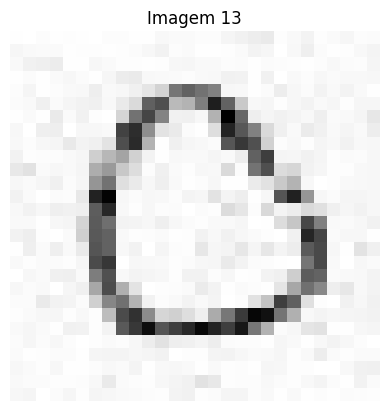

Fidelidade da imagem 13: 0.000000


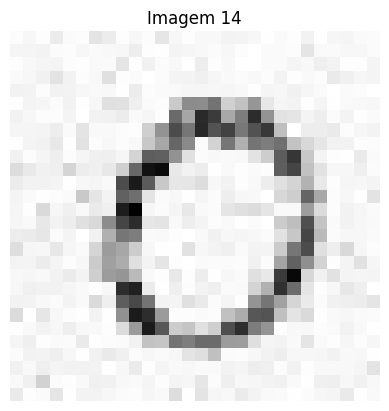

Fidelidade da imagem 14: 0.000007


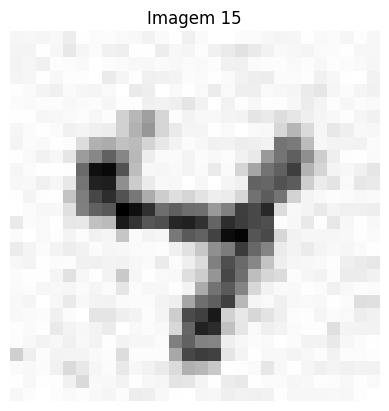

Fidelidade da imagem 15: 0.000078


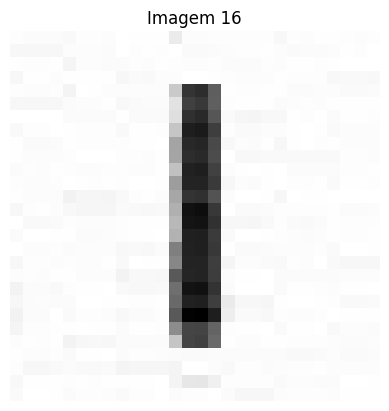

Fidelidade da imagem 16: 0.000004


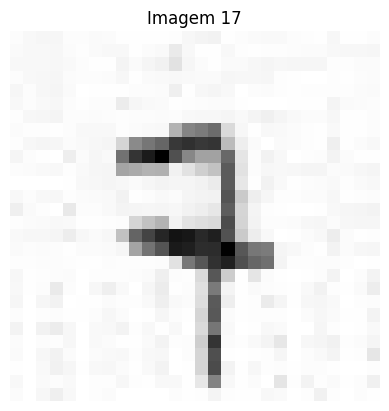

Fidelidade da imagem 17: 0.000013


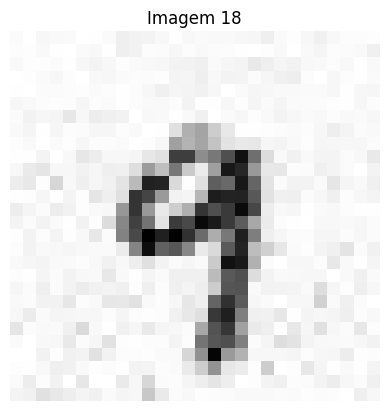

Fidelidade da imagem 18: 0.000022


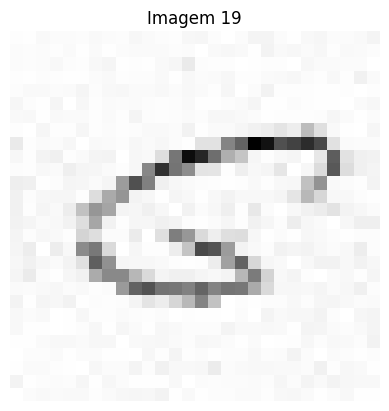

Fidelidade da imagem 19: 0.000006
Dados carregados: X.shape=(20, 4), y.shape=(20,)


In [ ]:
from qiskit.quantum_info import state_fidelity, Statevector
path = "base_test_mnist_784_f90/qasm/"

#if not os.path.isdir(path):
#    raise FileNotFoundError(f"Diretório não encontrado: {path}. Atualize a variável 'path' com o local correto dos QASM.")

file_list = sorted(os.listdir(path)) # pega os 20 primeiros arquivos para exemplo

states = []
labels = []

for i, file_name in enumerate(file_list):
    try:
        full_path = os.path.join(path, file_name)
        with open(full_path) as f:
            qasm = f.read()
            qc = QuantumCircuit.from_qasm_str(qasm)
            qc.save_statevector()
            compiled = transpile(qc, simulator)
            job = simulator.run(compiled)
            result = job.result()
            try:
                state = result.data(0)['statevector']
                state_sv = Statevector(state)#
                reference_state = np.zeros(state.dim, dtype=complex)#
                reference_state[0] = 1.0#
                fidelity = state_fidelity(state_sv, reference_state)#
                #show_state_figure(state, index=i)
                show_state_figure(state_sv, index=i, fidelity=fidelity)#
                print(f"Fidelidade da imagem {i}: {fidelity:.6f}")#
            except Exception:
                state = result.get_statevector(compiled)
            features = np.abs(state)
            features = features # reduz para 4 características (exemplo)
            states.append(features)
            labels.append(0 if i < 10 else 1)  # rótulo de exemplo: primeiros 10 -> classe 0, resto -> classe 1
    except Exception as e:
        print(f"Erro ao processar {file_name}: {str(e)}")

X = np.array(states)
y = np.array(labels)

if len(X) == 0:
    raise ValueError("Nenhum dado foi carregado corretamente! Verifique os arquivos QASM e o simulador.")
else:
    print(f"Dados carregados: X.shape={X.shape}, y.shape={y.shape}")


# Normalização e divisão dos dados

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

num_qubits = X.shape[1]
print(f"Num qubits (features) = {num_qubits}")


Num qubits (features) = 4


# Cria o circuito quântico (FeatureMap + Ansatz)

In [ ]:
# Construção do feature map e ansatz
feature_map = ZZFeatureMap(num_qubits, reps=10, entanglement="full")
ansatz = RealAmplitudes(num_qubits, reps=10, entanglement="full")

qc = QuantumCircuit(num_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

print('Circuito pronto. Depth aproximado:', qc.depth())


Circuito pronto. Depth aproximado: 2


# EstimatorQNN 

In [ ]:
estimator = Estimator(options={
    "backend": simulator,
    "resilience_level": 1,
    "approximation": True
})

qnn = EstimatorQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=estimator,
    input_gradients=True
)

vqc = NeuralNetworkClassifier(
    neural_network=qnn,
    loss=CrossEntropyLoss(),
    optimizer=COBYLA(maxiter=50),
    warm_start=True,
    callback=lambda weights, loss, step: enviar_circuito_por_epoca(
        circuito=feature_map.compose(ansatz.assign_parameters(weights)),
        epoch=step,
        num_qubits=num_qubits,
        circuit_depth=feature_map.compose(ansatz).depth()
    )
)

print('VQC (NeuralNetworkClassifier) configurado.')


VQC (NeuralNetworkClassifier) configurado.


/tmp/ipykernel_2763/3632900870.py:1: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator(options={
/tmp/ipykernel_2763/3632900870.py:7: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


# Treinamento

In [ ]:

print("\nTREINANDO VQC COM BACKEND RUIDOSO...\n")
vqc.fit(X_train, y_train)
print("Treinamento concluído.")


TREINANDO VQC COM BACKEND RUIDOSO...



Treinamento concluído.


# Avaliação: métricas

In [ ]:

print("\nCALCULANDO MÉTRICAS...\n")
y_pred = vqc.predict(X_test)

# Ajustes para formato binário
y_pred = np.round(y_pred).astype(int)
y_pred = np.clip(y_pred, 0, 1)

# CALCULAR MATRIZ DE CONFUSÃO
print("\n" + "="*50)
print("MATRIZ DE CONFUSÃO")
print("="*50)

cm = mostrar_matriz_confusao(y_test, y_pred, classes=['Classe 0', 'Classe 1'], title='Matriz de Confusão - VQC Quântico')

cm_norm = mostrar_matriz_confusao_normalizada(y_test, y_pred, classes=['Classe 0', 'Classe 1'], 
                              title='Matriz de Confusão Normalizada - VQC Quântico')
tn, fp, fn, tp = cm.ravel()

print(f"\nDetalhamento da Matriz de Confusão:")
print(f"Verdadeiros Negativos (TN): {tn}")
print(f"Falsos Positivos (FP): {fp}")
print(f"Falsos Negativos (FN): {fn}")
print(f"Verdadeiros Positivos (TP): {tp}")

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)

print("\nMÉTRICAS FINAIS:")
print(f"Acurácia : {accuracy:.4f}")
print(f"Precisão : {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

print("\nResultados Detalhados:")
print("Entradas:\n", X_test)
print("Saídas Previstas:\n", y_pred)
print("Saídas Reais:\n", y_test)




CALCULANDO MÉTRICAS...


MATRIZ DE CONFUSÃO

Matriz de Confusão - VQC Quântico
         Classe 0 Classe 1
         ------------------
Classe 0 |       0       2
Classe 1 |       0       2

Matriz de Confusão Normalizada - VQC Quântico
           Classe 0   Classe 1
         ----------------------
Classe 0 |     0.000     1.000
Classe 1 |     0.000     1.000

Detalhamento da Matriz de Confusão:
Verdadeiros Negativos (TN): 0
Falsos Positivos (FP): 2
Falsos Negativos (FN): 0
Verdadeiros Positivos (TP): 2

MÉTRICAS FINAIS:
Acurácia : 0.5000
Precisão : 0.5000
Recall   : 1.0000
F1 Score : 0.6667

Resultados Detalhados:
Entradas:
 [[2.33132314e-02 1.58798437e-03 2.34077465e-02 2.70143185e-02]
 [4.08666811e-06 6.37230116e-03 2.97310117e-01 1.20310536e-03]
 [5.22435307e-02 3.44709040e-03 2.71015639e-02 1.12037912e-01]
 [4.22837322e-03 1.69323796e-02 5.33894261e-02 3.90686497e-02]]
Saídas Previstas:
 [[1]
 [1]
 [1]
 [1]]
Saídas Reais:
 [0 0 1 1]


# Gráfico

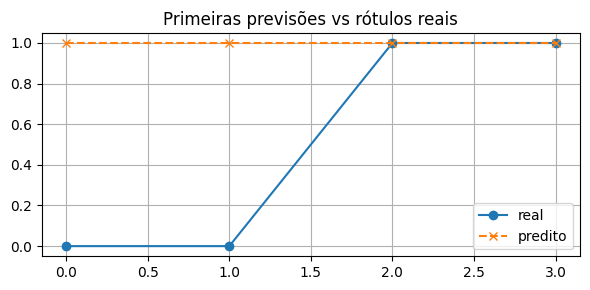

In [ ]:
plt.figure(figsize=(6,3))
plt.title('Primeiras previsões vs rótulos reais')
plt.plot(y_test, marker='o', label='real')
plt.plot(y_pred, marker='x', linestyle='--', label='predito')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()